In [1]:
import sncosmo
from   astropy.table import Table
import numpy as np
import matplotlib.pylab as plt

obs = Table({'time' : [56176.19, 56188.254, 56207.172],
             'band' : ['desg', 'desr', 'desi'],
             'gain' : [1., 1., 1.],
             'skynoise': [191.27, 147.62, 160.40],
             'zp'   : [30., 30., 30.],
             'zpsys':['ab', 'ab', 'ab']})

model  = sncosmo.Model(source='salt2')

### Reading SNTable in

In [2]:
filename = "/global/homes/a/anitab/DC2_run1p1_TransientDocs/Notebooks/Hosted_SN_table.csv"
from pandas import read_csv

In [3]:
vvv  = read_csv(filename)
data = vvv['galaxy_id c mB t0 x0 x1 z random_Hosting rand_host zbin "Unnamed: 0" diskMassStellar morphology/diskHalfLightRadiusArcsec morphology/diskMinorAxisArcsec morphology/positionAngle morphology/spheroidHalfLightRadiusArcsec morphology/spheroidMinorAxisArcsec size_bulge_true size_disk_true totalMassStellar uniqueId raJ2000_gal decJ2000_gal z zbin_gals snid']

In [4]:
vvv.columns

Index(['galaxy_id c mB t0 x0 x1 z random_Hosting rand_host zbin "Unnamed: 0" diskMassStellar morphology/diskHalfLightRadiusArcsec morphology/diskMinorAxisArcsec morphology/positionAngle morphology/spheroidHalfLightRadiusArcsec morphology/spheroidMinorAxisArcsec size_bulge_true size_disk_true totalMassStellar uniqueId raJ2000_gal decJ2000_gal z zbin_gals snid'], dtype='object')

In [114]:
length = 10000 #len(data)
zvals  = np.zeros(length) 
x0vals = np.zeros(length)
x1vals = np.zeros(length)
cvals  = np.zeros(length)
mBvals = np.zeros(length)
t0vals = np.zeros(length)
smass  = np.zeros(length)

for i in range(length):
    zvals[i]  = data[i].split()[6]
    x0vals[i] = data[i].split()[4]
    x1vals[i] = data[i].split()[5]
    cvals[i]  = data[i].split()[1]
    mBvals[i] = data[i].split()[2]
    t0vals[i] = data[i].split()[3]
    smass[i]  = data[i].split()[20]

In [ ]:
"""
print (" z limits: ")
print (np.min(zvals))
print (np.max(zvals))
print ()

print (" x0 limits: ")
print (np.min(x0vals))
print (np.max(x0vals))
print ()

print (" x1 limits: ")
print (np.min(x1vals))
print (np.max(x1vals))
print ()

print (" c limits: ")
print (np.min(cvals))
print (np.max(cvals))
print ()

print (" mB limits: ")
print (np.min(mBvals))
print (np.max(mBvals))
print ()
"""

In [115]:
params = []
for j, z in enumerate(zvals):
    mabs = mBvals[j] #np.random.normal(-19.3, 0.3)
    model.set(z=z)
    model.set_source_peakabsmag(mabs, 'bessellb', 'ab')
    x0 = model.get('x0')
    p = {'z':z, 't0':t0vals[j], 'x0':x0, 'x1': x1vals[j], 'c': cvals[j]}
    params.append(p)

#for p in params:
#    print (p)

In [116]:
lcs = sncosmo.realize_lcs(obs, model, params)
print (lcs[0])

   time   band      flux      fluxerr  zp  zpsys
--------- ---- -------------- ------- ---- -----
 56176.19 desg  134.520856463  191.27 30.0    ab
56188.254 desr  -11.262389629  147.62 30.0    ab
56207.172 desi -245.824629539   160.4 30.0    ab


In [117]:
from   astropy.cosmology import WMAP9 as cosmo
import astropy.units as u

def mu2(x0, x1, c,z, smassval):
    alpha  = 0.141
    beta   = 3.101
    DeltaM = -0.07
    mB     = 10.635 - (2.5 * np.log10(x0))
    dist   = cosmo.comoving_distance(lcs[0].meta['z'])
    dist  *= (1./u.Mpc)
    if smassval < 1e10:
        MB = -19.05
    else:
        MB = -19.05 + DeltaM
    val   = mB - (MB - (alpha * x1) + (beta * c))
    return val

Adding the condition on stellar mass did not change the distance modulus by anything noticable since the difference between MB value when considering stellar mass of the host galaxy or not was very small so it was expected, unfortunately!

In [118]:
vals = np.zeros(length)
zs   = np.zeros(length)
x0s  = np.zeros(length)
x1s  = np.zeros(length)
cs   = np.zeros(length)

mu = np.vectorize(mu2)

for i in range(length):
    vals[i] = mu(lcs[i].meta['x0'], lcs[i].meta['x1'], lcs[i].meta['c'], lcs[i].meta['z'], smass[i])
    zs[i]   = lcs[i].meta['z']
    x0s[i]  = lcs[i].meta['x0']
    x1s[i]  = lcs[i].meta['x1']
    cs[i]   = lcs[i].meta['c']

In [119]:
np.min(zs)

0.033126589233066606

### Distance modulus from theory

In [11]:
from   scipy              import interpolate, integrate

h  = 0.6726
H0 = h*100.

def chi_integrand(zprime):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        zprime: redshift values
        
    Return
    -------------------------------------------------------------------------------------------------
        Integrand of integral part in luminosity distance in Equation (3) in Kosowsky 2011.
        d(zprime)/ E(zprime)
    '''

    omegam = 0.316
    omegav = 0.684
    val    = 1./(np.sqrt(omegam*(1+zprime)**3 + omegav))
    return val

def chi_integral(z):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        z: redshift
        
    Return
    -------------------------------------------------------------------------------------------------
        Integral of the integral in luminsoty distance in Equation (3) in Kosowsky 2011.
        d(zprime)/ E(zprime) integrated from 0 to z
    '''
    
    c       = 3e5 #km/s
    val,err = integrate.quad(chi_integrand,0,z)
    return val

def mu_kosowsky(z):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        z: redshift
        
    Return
    -------------------------------------------------------------------------------------------------
        Distance modulus (mu) obtained from Equation (2) in Kosowsky
    '''
    
    c   = 3e5
    righthandside = (1+z) * (c/H0) * chi_integral(z)
    val = 2.17 * np.log(righthandside) + 25.
    return val

#### 3rd polynomial fit to points

In [120]:
indx = np.arange(0,length)
Z = [x for _,x in sorted(zip(zvals,indx))]

z = np.polyfit(np.sort(zs), vals[Z], 3)
p = np.poly1d(z)

#### Plotting mu(z) vs z from SNTable 

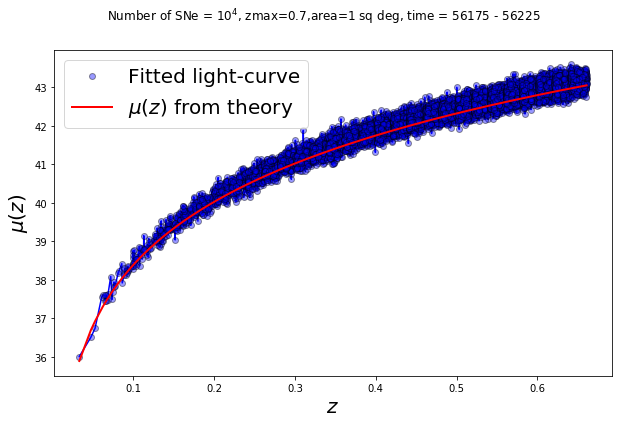

In [164]:
plt.figure(4, figsize=(10,6))


#plt.subplot(211)
# SNTable points fitted
plt.plot(np.sort(zs), vals[Z], "b", label="")
plt.plot(zs, vals, "bo", alpha=0.4, markeredgecolor="black", label="Fitted light-curve")

plt.xlabel("$z$", fontsize=20)
plt.ylabel("$\mu(z)$", fontsize=20)
plt.suptitle("Number of SNe = $10^4$, zmax=0.7,area=1 sq deg, time = 56175 - 56225")

# polynomial fit curve
#plt.plot(np.sort(zs), p(np.sort(zs)), color="orange", lw=2, label="3rd order polynomial fit")

# theory curve
mu_kosowsky_vec = np.vectorize(mu_kosowsky)
plt.plot(np.sort(zs), mu_kosowsky_vec(np.sort(zs)), color="red", lw=2, label="$\mu(z)$ from theory")
plt.legend(loc='best', prop={'size': 20})

#plt.savefig("mu_z_sne_params_SNTable.png", dpi=800)

#plt.subplot(212)
#plt.plot(np.sort(zs), vals[Z] -  mu_kosowsky_vec(np.sort(zs)), "bo", markeredgecolor="black", alpha=0.4)

#### Checking $\mu(z)$ values to compare with JLA

In [ ]:
print ("mu(z=0.1) = ", mu_kosowsky(0.1))
print ("mu(z=0.2) = ", mu_kosowsky(0.2))
print ("mu(z=0.4) = ", mu_kosowsky(0.4))
print ("mu(z=0.6) = ", mu_kosowsky(0.6))

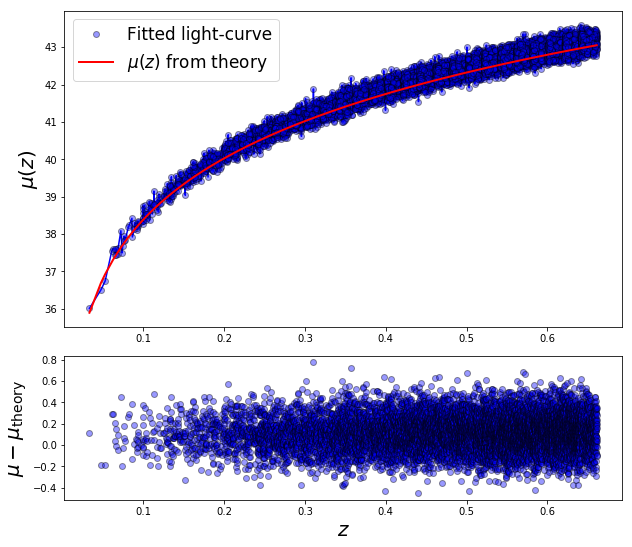

In [215]:
fig = plt.figure(figsize=(10, 9))
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax1.plot(np.sort(zs), vals[Z], "b", label="")
ax1.plot(zs, vals, "bo", alpha=0.4, markeredgecolor="black", label="Fitted light-curve")
ax1.plot(np.sort(zs), mu_kosowsky_vec(np.sort(zs)), color="red", lw=2, label="$\mu(z)$ from theory")
plt.ylabel("$\mu(z)$", fontsize=20)
plt.legend(loc='best', prop={'size': 17})

ax2 = plt.subplot2grid((3,1), (2,0))
ax2.plot(np.sort(zs), vals[Z] -  mu_kosowsky_vec(np.sort(zs)), "bo", markeredgecolor="black", alpha=0.4)

plt.xlabel("$z$", fontsize=20)
plt.ylabel("$\mu - \mu_{\mathrm{theory}}$",fontsize=20)

#plt.savefig("mu_z_sne_params_SNTable_noerr.png", dpi=800)

#plt.show()

Comparing this with values from JLA (http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html) shows that my distance modulus plot is in agreement with actual supernovae data so I am convinced that this function works fine!

In [121]:
data1 = lcs

In [15]:
data1[0]

time,band,flux,fluxerr,zp,zpsys
float64,str4,float64,float64,float64,str2
56176.19,desg,-37.7169472029,191.27,30.0,ab
56188.254,desr,-52.5674032656,147.62,30.0,ab
56207.172,desi,58.1523414362,160.4,30.0,ab


In [ ]:
#from astropy.io import ascii
#ascii.write(data1, 'blah.dat', names=['time', 'band', 'flux', 'fluxerr','zp', 'zpsys'])

In [122]:
x0err = np.zeros(length)
x1err = np.zeros(length)
cerr  = np.zeros(length)
t0err = np.zeros(length)
counter = []

for w in range(length):
    try:
        result, fitted_model = sncosmo.fit_lc(data1[w], model, ['t0', 'x0', 'x1', 'c'], minsnr = 0.01, bounds={'z':(np.min(zvals), np.max(zvals))})
        x0err[w] = result['errors']['x0'] 
        x1err[w] = result['errors']['x1'] 
        cerr[w]  = result['errors']['c'] 
        t0err[w] = result['errors']['t0'] 
        counter.append(w)
    except:
        pass

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/models.py:670: RuntimeWarning: overflow encountered in power
  self._model['clbase'](wave)**self._parameters[2])
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/models.py:136: RuntimeWarning: invalid value encountered in multiply
  fsum = np.sum(f * b.trans * b.wave * b.dwave, axis=1) / HC_ERG_AA
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56114.600928
    x0 = +4588496150650.509766
    x1 

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56236.514357
    x0 = +69860676.956893
    x1 = -42.318830
     c = -2101.387700

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56093.708366
    x0 = +64052.486705
    x1 = -190.277293
     c = -687.869628

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sn

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56093.511517
    x0 = -50294592.349226
    x1 = -3.942869
     c = -124.455772

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56095.223275
    x0 = +6128596.048913
    x1 = +19.136775
     c = +972.186088

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/snc

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56129.611726
    x0 = -360680.467788
    x1 = -13033.308451
     c = -1026.909378

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56109.052355
    x0 = +37898051.894819
    x1 = -4.195380
     c = -304.872319

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56136.587068
    x0 = -14331219.068644
    x1 = +12.996579
     c = -99.564782

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56240.145458
    x0 = +1007425.276028
    x1 = -4207.552716
     c = -124.697356

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/s

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56097.038368
    x0 = +7721228662.966635
    x1 = +77.548109
     c = -1659.354515

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56231.726248
    x0 = +165335114.193346
    x1 = -22.732109
     c = -639.441693

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/pyth

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56108.956476
    x0 = +24528432.100143
    x1 = +9.086775
     c = -363.656685

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56230.726293
    x0 = +6206580337.778835
    x1 = +13.512809
     c = -156.413417

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56124.424026
    x0 = +28853300.096832
    x1 = -26.236863
     c = -99.509756

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56197.740757
    x0 = +194442882791.570862
    x1 = -55.799560
     c = +4281.238085

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/pyth

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56165.050092
    x0 = +0.002327
    x1 = -1.571375
     c = -77.893209

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56240.075708
    x0 = -28067779.910399
    x1 = +2.586322
     c = -229.440950

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56212.520359
    x0 = +257353367.042409
    x1 = +3.166787
     c = -540.789005

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56124.588834
    x0 = -518.858159
    x1 = +1049.079691
     c = -101.538317

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/snco

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56143.631699
    x0 = +1036682970150.542236
    x1 = -44.935136
     c = -301165.396608

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56132.139694
    x0 = -435509075.618798
    x1 = -3.376691
     c = -219.425471

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56105.206708
    x0 = +75900.945261
    x1 = +2.796295
     c = -427.924303

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56191.887117
    x0 = -15641290.617274
    x1 = +34.817430
     c = -6405.567225

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/snco

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56239.129044
    x0 = +507416.294162
    x1 = +9.942943
     c = -592.239307

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56115.726643
    x0 = +834700812046.558472
    x1 = +2471.465590
     c = -2093630.141849

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/p

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56157.813725
    x0 = +0.204995
    x1 = +279.824681
     c = -96.495739

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56093.370404
    x0 = -76478.991376
    x1 = -21.718105
     c = -64.660041

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56146.229983
    x0 = +51919383.558334
    x1 = -26675.945886
     c = -348.708583

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56139.678604
    x0 = +1654970852.967770
    x1 = -39.288547
     c = -11805.739060

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/p

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56238.362577
    x0 = -22643543.935349
    x1 = -18.237382
     c = -88.073290

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56125.243619
    x0 = -4958343.401187
    x1 = -25.570791
     c = -84.020640

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/snco

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56100.215507
    x0 = -426264737.306007
    x1 = +34.714074
     c = -1773.582354

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56151.247110
    x0 = -1506412099.728939
    x1 = -2850.745186
     c = -324872.257487

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56114.810320
    x0 = +7442052.341428
    x1 = -12.643630
     c = -118.089107

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56236.090241
    x0 = -9363518502.107140
    x1 = -573.789509
     c = -86.122262

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56139.926228
    x0 = -323801824.372184
    x1 = -1.340833
     c = +32010.937951

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56103.691657
    x0 = -0.000371
    x1 = -31.990892
     c = -268.088682

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosm

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56225.857824
    x0 = +215103862.829777
    x1 = +0.258986
     c = -165.901092

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56142.023673
    x0 = -0.000007
    x1 = -22.414052
     c = -290.493103

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56118.742071
    x0 = -35471230917.105370
    x1 = +248.291750
     c = -99315.325370

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56228.680898
    x0 = +80167371.123583
    x1 = +10.846063
     c = -400.499758

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/py

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56137.480181
    x0 = -475291.501702
    x1 = +291.674134
     c = +9173.092054

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56240.295074
    x0 = -0.021896
    x1 = -17.258016
     c = -64.537277

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56224.188908
    x0 = -2372633.689195
    x1 = -3.468532
     c = -97.140420

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56145.526705
    x0 = +0.000825
    x1 = +0.397655
     c = -64.826527

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56215.697443
    x0 = +269376406.863153
    x1 = +2.332542
     c = -8353.594910

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56093.483986
    x0 = -0.002829
    x1 = -8.003785
     c = -134.038296

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56179.451704
    x0 = -334610.725898
    x1 = -31809.748639
     c = -1469.554800

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56225.183071
    x0 = +16844425296.783493
    x1 = -22.398602
     c = -5043.962414

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/py

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56101.890607
    x0 = +6365239.247028
    x1 = -6.043539
     c = -80.588428

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/python/sncosmo-1.3.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656486
    t0 = +56144.934312
    x0 = -462783659944.925354
    x1 = +1453.550584
     c = -747762.093369

  d, l = m.migrad(ncall=maxcall)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.13_sims2.7.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sncosmo/12.0-1-g5e70e90+4/lib/py

In [57]:
#result, fitted_model = sncosmo.fit_lc(data1[0], model, ['t0', 'x0', 'x1', 'c'], minsnr = 0.01)  

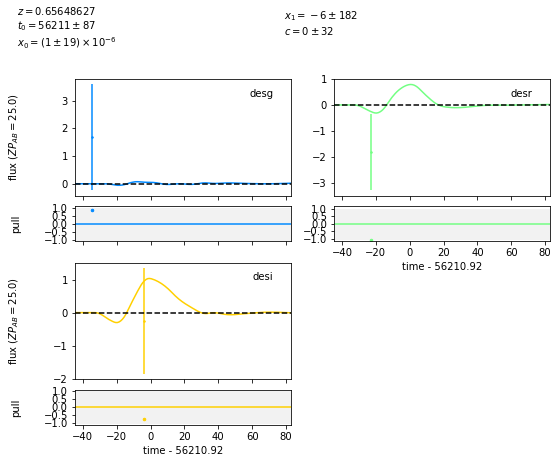

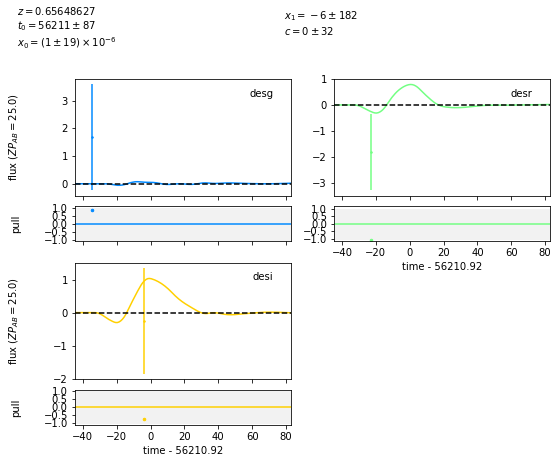

In [124]:
sncosmo.plot_lc(data1[20], model=fitted_model, errors=result.errors)

In [58]:
fitted_model.parameters

array([  2.83534268e-01,   5.62053706e+04,   7.73052570e-07,
        -1.80329206e+01,  -5.05886625e-02])

In [59]:
result['errors']

OrderedDict([('t0', 99.2057579486318),
             ('x0', 2.147279583756339e-05),
             ('x1', 227.49458168720258),
             ('c', 20.091297471010463)])

In [62]:
lcs[0].meta

{'c': -0.019523983646587639,
 't0': 61171.381392818315,
 'x0': 0.0036467050649098467,
 'x1': 1.1963657619373145,
 'z': 0.033126589233066606}

In [125]:
def sigma_mB(x0, sigma_x0):
    final_val = (((-2.5/np.log(10)) * (1./x0))**2) *  (sigma_x0**2)
    return np.sqrt(final_val)

In [126]:
def sigma_mu(sigma_mBval, sigma_x1, sigma_c):
    alpha     = 0.141
    beta      = 3.101
    val_err   = (sigma_mBval**2) + ((alpha**2) * (sigma_x1**2)) + ((beta**2) * (sigma_c**2)) 
    final_val = np.sqrt(val_err)
    return final_val

In [127]:
sigma_mb_arr = np.zeros(length)

for v in range(length):
    sigma_mb_arr[v] = sigma_mB(x0vals[v], x0err[v])

In [128]:
np.max(sigma_mb_arr)

1.5089344079486796e-09

In [129]:
sigma_mu_arr = np.zeros(length)

for ff in range(length):
    sigma_mu_arr[ff] = sigma_mu(sigma_mb_arr[ff], x1err[ff], cerr[ff])

In [133]:
np.mean(sigma_mu_arr)

44.572298945365993

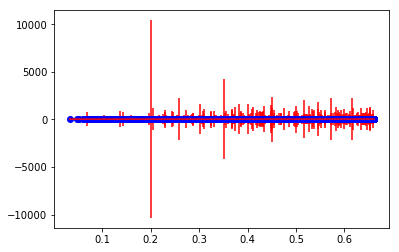

In [131]:
plt.errorbar(np.sort(zs), vals[Z], yerr= sigma_mu_arr, color="red")
plt.plot(np.sort(zs), vals[Z], "ob", label="")

#plt.plot(np.sort(zs), vals[Z], "b", label="")
#plt.plot(zs, vals, "bo", alpha=0.4, markeredgecolor="black", label="Fitted light-curve")

In [134]:
indx_good = np.where((sigma_mu_arr < 3) & (sigma_mu_arr > 0) ) 

In [135]:
np.shape(indx_good)

(1, 1079)

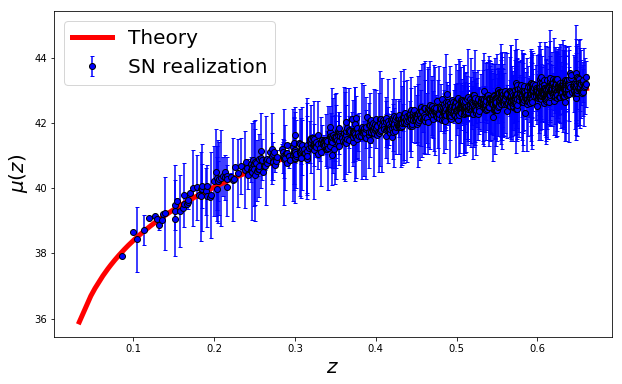

In [218]:
plt.figure(figsize=(10, 6))
plt.errorbar(np.sort(zs)[indx_good], vals[Z][indx_good], yerr= sigma_mu_arr[indx_good]/2., color="blue", markeredgecolor="black", fmt='o', capsize=2, label="SN realization")
#plt.plot(np.sort(zs)[indx_good], vals[Z][indx_good], "ob", label="")

#errlow  =  vals[Z][indx_good] - sigma_mu_arr[indx_good]/2.
#errhigh =  vals[Z][indx_good] + sigma_mu_arr[indx_good]/2.
#plt.fill_between(np.sort(zs)[indx_good], errlow, errhigh, color="lightskyblue",alpha=0.95,label="28 patches")

plt.plot(np.sort(zs), mu_kosowsky_vec(np.sort(zs)), color="red", lw=5, label="Theory")


plt.xlabel("$z$", fontsize=20)
plt.ylabel("$\mu(z)$", fontsize=20)
plt.legend(loc='best', prop={'size': 20})

plt.savefig("mu_z_sne_params_SNTable_err.png", dpi=800)


In [139]:
np.max(sigma_mu_arr[indx_good])

2.9957515148496743